In [1]:
from panel_segmentation.lidar import pcd_data, plane_segmentation, usgs_lidar_api
from panel_segmentation import utils
from shapely.wkt import loads
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
import numpy as np
import cv2
from mmengine import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import mmcv
from shapely.geometry import Polygon
import torch
import geopandas
import warnings
import pandas as pd
warnings.filterwarnings(action='once')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Estimating Solar Panel's Tilt and Azimuth through LiDAR

Calculating a solar panel's tilt and azimuth is often a manual process and the process can be tedious, especially when looking at hundreds of solar installations. This Juypter notebook example shows an automated process in estimating a solar panel's tilt and azimuth through LiDAR.

Light Detection and Ranging (LiDAR) is a remote sensing technology that uses light pulses, usually from lasers, to collect 3D coordinate points of terrains and buildings. These 3D x, y, z coordinate points are called point cloud data (PCD). LiDAR files are saved as .laz or .las files and can contain millions of point cloud data. LiDAR is often used in a geographical setting to create high-resolution maps of terrains, buildings, and other environmental objects. More information of LiDAR can be found on the [USGS website](https://www.usgs.gov/faqs/what-lidar-data-and-where-can-i-download-it).

The United States Geological Survery (USGS) provides free LiDAR data that covers most regions throughout the US. These data can be found through their [LiDAR Explorer page](https://apps.nationalmap.gov/lidar-explorer/#/) or through their [online database](https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/). This example specifically uses USGS data. 

The process for estimating the tilt and azimuth through LiDAR can be broken down into 5 main steps.
<br>1) Generate a shapely polygon of EPSG:4326 latitude, longitude coordinates that outlines the solar panel. 
<br>2) Download or provide the associated .laz file containing the shapely polygon.
<br>3) Crop and filter the LiDAR PCD to only include points within the shapely polygon.
<br>4) Generate planes from the filtered PCD and calculate the plane's tilt and azimuth from its normal vectors.
<br>5) Merge similar planes and calculate the tilt and azimuth from the "best" merged plane.



## 1) Get Latitude, Longitude Shapely Polygon

A shapely polygon is needed to crop and filter the LiDAR data to get the correct solar panel location for tilt and azimuth estimations.

### 1a) Generate Inference Masks from Satellite Imagery

Shapely polygons can be automatically generated for a solar panel given a satellite imagery. This is done by creating masks from inferences through the panel detection pipeline. See [Austin_hail_damage_example.ipynb](./Austin_hail_damage_example.ipynb) or [Sol-Searcher_example.ipynb](./Sol-Searcher_example.ipynb) for a more in-depth tutorial and explanation.

D:\GitHub_repos\all_venv\lidar_venv3\Lib\site-packages\mmcv\cnn\bricks\transformer.py:24: ImportWarning: ``MultiScaleDeformableAttention`` has been moved to ``mmcv.ops.multi_scale_deform_attn``, please change original path ``from mmcv.cnn.bricks.transformer import MultiScaleDeformableAttention`` to ``from mmcv.ops.multi_scale_deform_attn import MultiScaleDeformableAttention`` 
  warnings.warn(
D:\GitHub_repos\all_venv\lidar_venv3\Lib\site-packages\mmdet\apis\inference.py:70: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')
D:\GitHub_repos\all_venv\lidar_venv3\Lib\site-packages\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
D:\GitHub_repos\all_venv\lidar_venv3\Lib\site-packages\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp

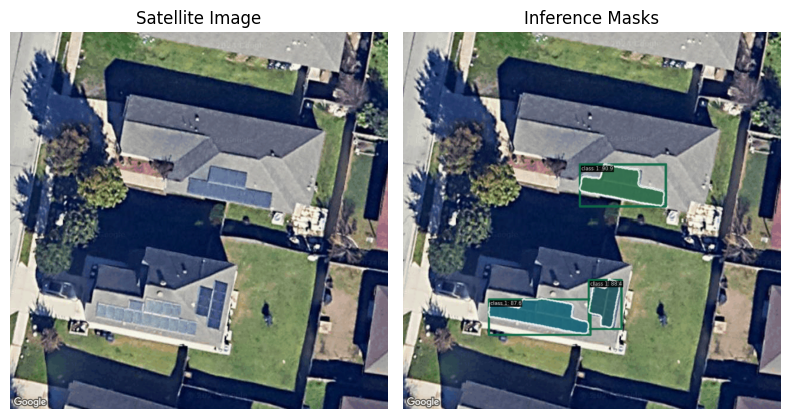

In [2]:
# Plot satellite image and inferences side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Select a satellite image to run inferences
satellite_img_path = ("./panel_segmentation/examples/" +
                      "lidar_tilt_azimuth_detection_examples/30.1478_-97.74105.png")
coords = os.path.basename(satellite_img_path).replace(".png", "").split("_")
img_center_lat, img_center_lon = float(coords[0]), float(coords[1])
img = Image.open(satellite_img_path)
ax1.imshow(img)
ax1.set_title("Satellite Image")
ax1.axis("off")

# locate the model used to generate inferences
cfg = Config.fromfile("./panel_segmentation/models/hail_config.py")
checkpoint_file = "./panel_segmentation/models/hail_model.pth"
model = init_detector(cfg, device='cpu')
checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
visualizer = VISUALIZERS.build(model.cfg.visualizer)

# Run inference on the single image
img_array = mmcv.imread(satellite_img_path, channel_order='rgb')
result = inference_detector(model, img_array)
# Visualize the result
visualizer.add_datasample(
    satellite_img_path,
    img_array,
    data_sample=result,
    draw_gt=None,
    wait_time=0,
    pred_score_thr=0.35
)
# Add image information to result
result.img = img_array
result.file = satellite_img_path
# Visualize the inferences
visualizer_img = visualizer.get_image()
ax2.imshow(visualizer_img)
ax2.set_title("Inference Masks")
ax2.axis("off")
plt.tight_layout()
plt.show()

### 1b) Convert Inference Masks to Lat, Lon Shapely Polygons

After using a deep learning model to detect solar panels and get inference masks from a satellite image, we can convert those binary masks into latitude, longitude coordinate polygons.

In [3]:
# Generate shapely polygons from inferences
predictions = result._pred_instances
masks = predictions.masks
labels = predictions.labels
scores = predictions.scores
# Take all labels meeting a 0.35 threshold or greater
idx_to_keep = np.argwhere(scores >= 0.35).tolist()[0]
file_name = os.path.basename(result.file)
image_x_pixels, image_y_pixels = result.img_shape
# Convert all of the masks to latitude-longitude-based polygons
inference_data_list = list()
for index in range(len(masks)):
    if index in idx_to_keep:
        segmentation_mask = masks[index].data.cpu().numpy()
        # Convert the mask to a polygon
        polygon_lat_lon_coords = utils.convertMaskToLatLonPolygon(
            segmentation_mask, img_center_lat, img_center_lon,
            image_x_pixels, image_y_pixels, zoom_level=21)
        # Convert to a geoJSON
        shapely_poly = Polygon(polygon_lat_lon_coords)
        geojson_poly = geopandas.GeoSeries(shapely_poly).to_json()
        inference_data_list.append({"image": result.file,
                                    "poly": shapely_poly,
                                    "poly_centroid_lon": shapely_poly.centroid.x,
                                    "poly_centroid_lat": shapely_poly.centroid.y,
                                    "area": shapely_poly.area,
                                    "label": int(labels[index])})

inference_df = pd.DataFrame(inference_data_list)
inference_df.head(10)

,image,poly,poly_centroid_lon,poly_centroid_lat,area,label
0,./panel_segmentation/examples/lidar_tilt_azimu...,"POLYGON ((-97.7410372702614 30.14785415189192,...",-97.741017,30.147833,2.060606e-09,1
1,./panel_segmentation/examples/lidar_tilt_azimu...,POLYGON ((-97.74103191039197 30.14774177215681...,-97.741035,30.147719,1.025230e-09,1
2,./panel_segmentation/examples/lidar_tilt_azimu...,POLYGON ((-97.74110761874037 30.14772255695745...,-97.741107,30.147707,2.214505e-09,1


## 2) Get the .laz File that Contains the Shapely Polygon

All USGS LiDAR dataset is pulled via a custom [USGS LiDAR API](./panel_segmentation/lidar/usgs_lidar_api.py) within the panel segmentation package. Using this API, the [master_usgs_lidar_dataset_names.parquet](./panel_segmentation/lidar/data/master_usgs_lidar_dataset_names.parquet) and [master_usgs_lidar_metadata.parquet](./panel_segmentation/lidar/data/master_usgs_lidar_metadata.parquet) are generated and saved in memory within the [data](./panel_segmentation/lidar/data/) folder. See [USGS_LiDAR_API_Example.ipynb](./USGS_LiDAR_API_Example.ipynb) for an in-depth tutorial and explanation.

Using master_usgs_lidar_metadata.parquet, we can get the latest .laz file associated with the shapely polygon. This is done by getting a latitude, longitude coordinate within the polygon and checking if the coordinate is within the scan boundaries of the LiDAR file. If multiple LiDAR files are found, the most recent .laz file is selected. If no LiDAR files are found, then running the LiDAR pipeline to get tilt and azimuth cannot be done. This process is already written in the locateLazFileByLatLon() function in the [USGS LiDAR API](./panel_segmentation/lidar/usgs_lidar_api.py). To execute the function, read in the master_usgs_lidar_metadata.parquet file as a Pandas dataframe and provide a latitude, longitude coordinate within the polygon. This function locates the downloadable URL and downloads the .laz file in lidar_laz folder located in the output folder used in the initialization of the class. 


Using the generated inferences from the previous cell, we can download the .laz file that contains the polygon's center latitude, longitude coordinates.

In [4]:
# Point to output folder where results are saved
example_output_folder = "./panel_segmentation/examples/lidar_tilt_azimuth_detection_examples"
# Initialize the USGSLidarAPI class
lidar_api = usgs_lidar_api.USGSLidarAPI(example_output_folder)

# Read in master metadata file
metadata_df = pd.read_parquet("./panel_segmentation/lidar/data/master_usgs_lidar_metadata.parquet")
laz_download_link_set = set()
# Get the .laz file that contains the shapely polygon coordinates
for lat, lon in zip(inference_df["poly_centroid_lat"], inference_df["poly_centroid_lon"]):
    laz_download_link = lidar_api.locateLazFileByLatLon(metadata_df, lat, lon)
    laz_download_link_set.add(laz_download_link)
    
# Download laz file
laz_file_path_list = []
for link in laz_download_link_set:
    laz_file_path = lidar_api.downloadLazFile(link)
    laz_file_path_list.append(laz_file_path)
print("Local Laz File Path:", laz_file_path_list)

USGS_LPC_TX_Central_B1_2017_stratmap17_50cm_3097513c1_LAS_2019.laz already downloaded.
Local Laz File Path: ['./panel_segmentation/examples/lidar_tilt_azimuth_detection_examples\\lidar_laz\\USGS_LPC_TX_Central_B1_2017_stratmap17_50cm_3097513c1_LAS_2019.laz']


The shapely polygons are contained within one .laz file in this example. However, for some buildings, it may be split into two or more .laz files. 

## 3) Crop and Filter LiDAR Point Cloud Data

.laz files are large and can contain millions of point cloud data. From these .laz file, we only need to get the rooftop surfaces where the solar panels are located. This is can done by using the shapely polygon and cropping the LiDAR PCD to only contain points inside that polygon.

For simplicity, only one polygon from inference_df will be used to clearly show the results and figures of the following steps. Steps 3 to 5 can be repeated for each polygon using a for loop if there are multiple polygons. The loop can also be parallelized with ThreadPoolExecutor for much faster processing.

In [5]:
# Get one polygon from inference_df
shapely_poly = inference_df["poly"].iloc[0]
# Initialize pcd class with shapely polygon
laz_file_path = laz_file_path_list[0]
pcd_class = pcd_data.PCD(laz_file_path, polygon=shapely_poly)
# Read in data from .laz file
original_laz_data = pcd_class.readLaz()
print(original_laz_data)

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 21510402 points, 3 vlrs)>


The output from the previous cell returns a laspy.LasData object, which contains metadata information about the lidar data. This information includes the crs (coordinate reference system), total point counts, scales, offsets, etc.

After reading in the .laz file and making a laspy.LasData object, we can crop the .laz file to contain points within the shapely polygon. 

We can also filter these points to only contain building or unclassified points to reduce noise in the data. Each LiDAR point is assigned a classification number and that classification number maps to a classification name. This mapping is prodvided by the [standardized classification](https://www.asprs.org/wp-content/uploads/2019/03/LAS_1_4_r14.pdf) for LiDAR points by ASPRS (American Society for Photogrammetry and Remote Sensing). Here, we choose 1 and 6 classification number since those classifications likely give us rooftop points.

| Classification Number | Classification Name |
|:----:|:---------------|
| 0 | Never classified |
| 1 | Unclassified |
| 2 | Ground |
| 3 | Low Vegetation |
| 4 | Medium Vegetation |
| 5 | High Vegetation |
| 6 | Building |
| 7 | Low Point (Noise) |
| 8 | Reserved |
| 9 | Water |
| 10 | Rail |
| 11 | Road Surface |
| 12 | Reserved |
| 13 | Wire - Guard Shield |
| 14 | Wire - Conductor |
| 15 | Transmission Tower |
| 16 | Wire - Structure Connector |
| 17 | Bridge Deck |
| 18 | High Noise |
| 19 | Overhead Structure |
| 20 | Ignored Ground |
| 21 | Snow |
| 22 | Temporal Exclusion |
| 23-63 | Reserved |
| 64-244 | User-Defined|

By filtering the example data, we reduced the point count from 221,510,402 points to 183 points.

In [6]:
# Filter pcd
filtered_laz_data = pcd_class.filterLaz(original_laz_data, classification_list=[1, 6])
print(filtered_laz_data)

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 183 points, 3 vlrs)>


We can now preprocess the laz data and make it into an o3d.geometry.PointCloud object for further processing and filtering of any outlier data.

In [7]:
# Preprocess pcd
preprocessed_pcd = pcd_class.preprocessPcd(filtered_laz_data)
# Metadata associated with the pcd to reference later
source_crs = pcd_class.source_crs
scales = pcd_class.scales
offsets = pcd_class.offsets
transformer = pcd_class.transformer

For visualization purposes, we can plot the preprocessed pcd and shapely polygon on one plot. 

Visualizing pcd can easily be done with [o3d.visualization.draw_geometries()](https://www.open3d.org/docs/latest/python_api/open3d.visualization.draw_geometries.html) function. However, this opens a new browser with the displayed figure. To keep the figures inline with the Juypter notebook and avoid pop-up browsers, the following example will use matplotlib.pyplot to plot the pcd data and shapely polygon.

Additionally, for the following example plot, we are plotting a 2D polygon in a 3D space. This 2D polygon originally does not have a z component and for simplicity, we can get its z component by averaging the z value of all points. This makes the polygon look flat when in reality, it should have a tilt. Again, this is only for visualization purposes to visualize the preprocessed pcd within the shapely polygon so a tilt is not necessary.

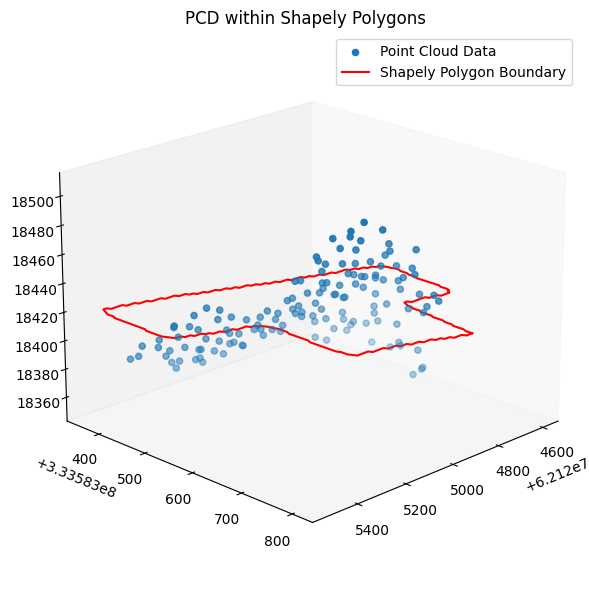

In [8]:
# Visualize preprocessed pcd on a plot
# First, convert open3d pcd to numpy array
points = np.asarray(preprocessed_pcd.points)
# Create a 3d scatter plot with the points
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], label="Point Cloud Data")

# Get shapely polygon and project them ontop of lidar data
transformed_coords = []
for lon, lat in list(shapely_poly.exterior.coords):
    x, y = transformer.transform(lon, lat)
    x_coord = (x - offsets[0]) / scales[0]
    y_coord = (y - offsets[1]) / scales[1]
    # Get average z coord
    z_coord = np.mean(np.asarray(preprocessed_pcd.points)[:, 2])
    transformed_coords.append([x_coord, y_coord, z_coord])
# Convert to numpy array
transformed_coords = np.array(transformed_coords)
# Plot the polygon line
x_coords = transformed_coords[:, 0]
y_coords = transformed_coords[:, 1]
z_coords = transformed_coords[:, 2]
ax.plot(x_coords, y_coords, z_coords, "r-", label="Shapely Polygon Boundary")

# Remove grid
ax.grid(False)
# Set view for a better look at the pcd
ax.view_init(elev=20, azim=45)
plt.title("PCD within Shapely Polygons")
plt.legend()
plt.tight_layout()
plt.show()

## 4) Generate Planes and Calculate its Tilt and Azimuth

Given a number of 3D points, a plane can be generated from those points. An algorithm to do this is the RANSAC algorithm. More information about how the RANSAC generates plane can be found [here](https://summergeometry.org/sgi2022/plane-and-edge-detection-by-the-random-sample-consensus-ransac-algorithm/). Fortunately, the open3d package already has this implementation and we can call segment_planes function on the point cloud data to get the planes associated with the pcd. For more information about this implementation refer to the Plane Segmentation portion of the [open3d pcd tutorial](https://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html).

From the planes, we can calculate its tilt and azimuth through the plane's normal vectors. The metadata information of each generated plane can be summarized in the following dataframe.

In [9]:
# Initialize PanelSegmentation class with preprocessed pcd
ps = plane_segmentation.PlaneSegmentation(preprocessed_pcd)
# Segment lidar points into planes
ps.segmentPlanes()

# Create a dataframe that summarizes the plane's metadata like tilt and azimuth
all_plane_df = ps.createSummaryPlaneDataframe(source_crs, scales, offsets)
all_plane_df.head(10)


,plane_id,tilt,azimuth,num_points,center_lat,center_lon
0,0,22.617913,189.955867,53,30.147831,-97.741010
1,1,22.907439,189.891597,38,30.147831,-97.741011
2,2,22.766539,190.069152,13,30.147828,-97.741011
3,3,23.048180,282.605510,11,30.147840,-97.741042
4,4,21.830277,277.540765,7,30.147839,-97.741045
5,5,22.503501,190.443616,6,30.147832,-97.741013
6,6,20.360471,272.118473,4,30.147840,-97.741045
7,7,28.836529,294.445466,3,30.147845,-97.741039


For visualization purposes, lets plot the mesh planes with the pcd that generates those planes. Again, visualizing point cloud data and mesh planes can be easily done by calling the [o3d.visualization.draw_geometries()](https://www.open3d.org/docs/latest/python_api/open3d.visualization.draw_geometries.html), but to avoid pop-up browser, matplotlib will be used.

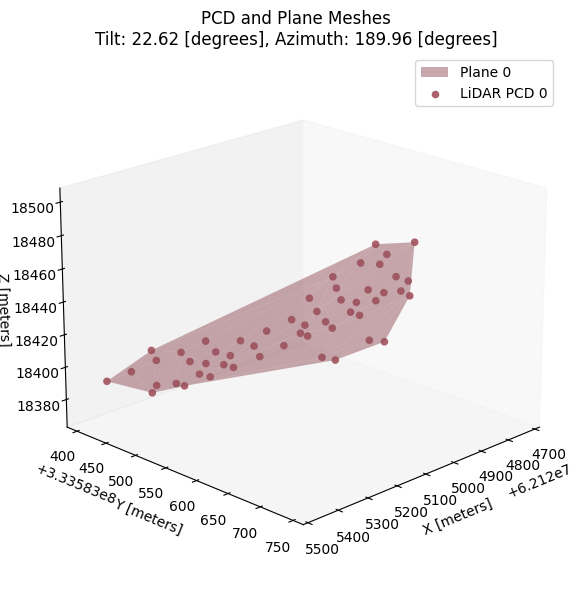

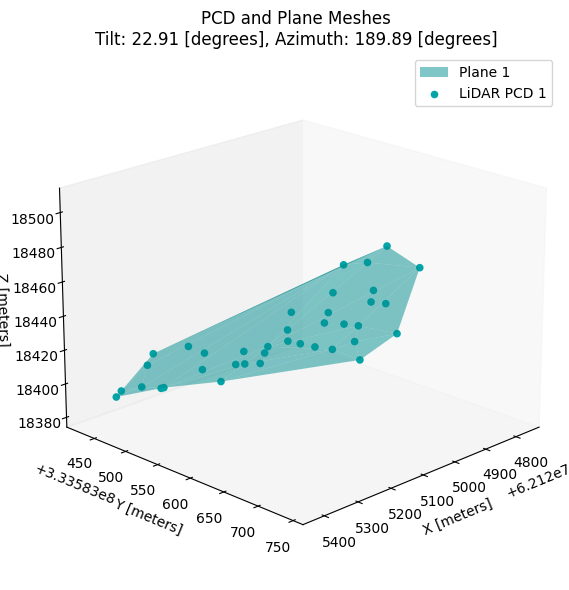

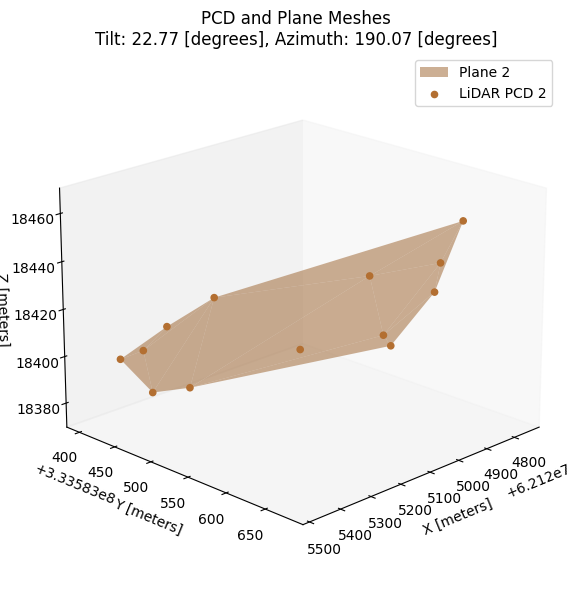

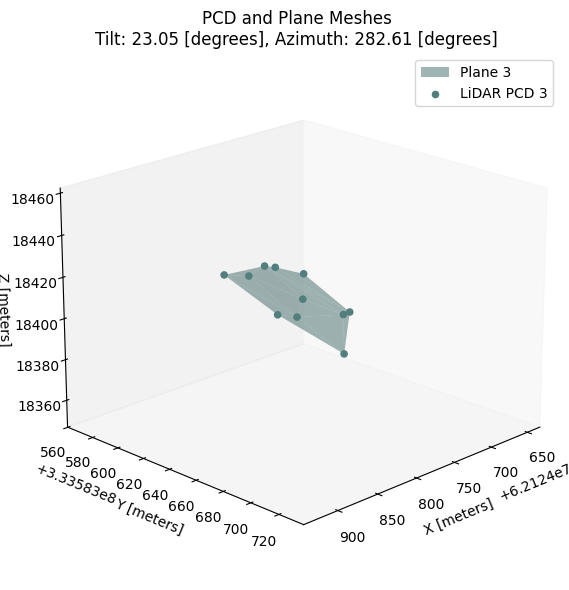

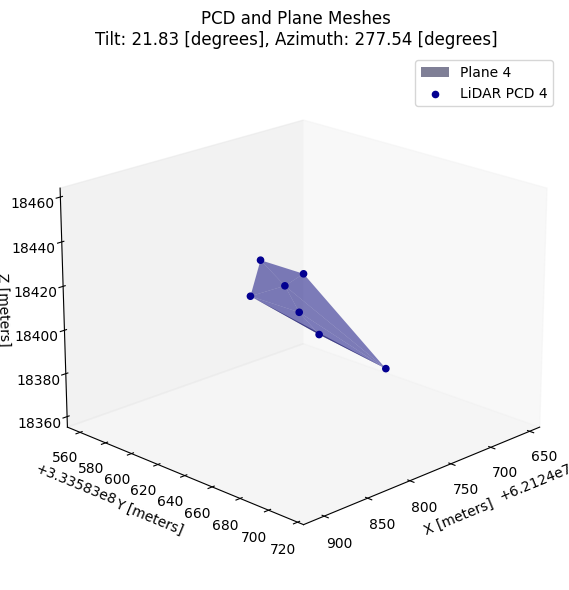

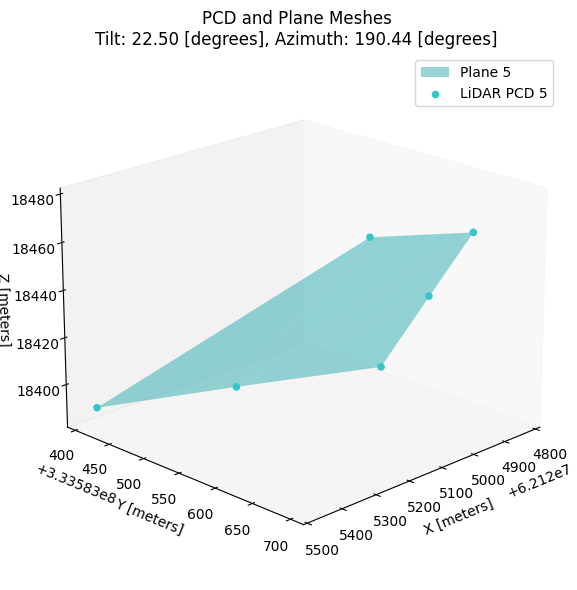

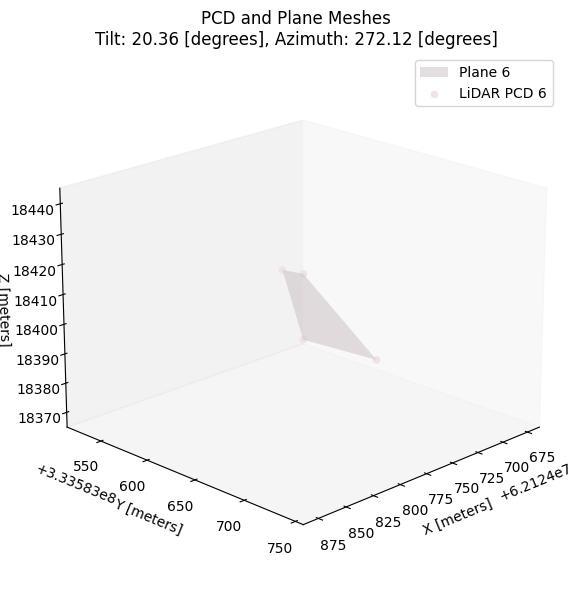

In [10]:
# Create plane mesh for visualization 
pcd_plane_mesh_list = ps.visualizePlanes()

# Iterate through the plane_mesh_list and plot the points/mesh on the same plot
for pcd_dict, tilt, azimuth in zip(pcd_plane_mesh_list, all_plane_df["tilt"], all_plane_df["azimuth"]):
    plane_mesh = pcd_dict["plane_mesh"]
    # Check is a plane was made for the pcd
    # If no plane is made, don't plot it
    if plane_mesh is not None:
        plane_id = pcd_dict["plane_id"]
        pcd = pcd_dict["pcd"]
        color = pcd_dict["color"]
        # Make a new figure for each plane
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        # Plot the plane mesh
        vertices = np.asarray(plane_mesh.vertices)
        triangles = np.asarray(plane_mesh.triangles)
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                       color=color, label=f"Plane {plane_id}", alpha=0.5)
        # Plot the pcd
        mesh_points = np.asarray(pcd.points)
        ax.scatter(mesh_points[:, 0], mesh_points[:, 1], mesh_points[:, 2],
                   color=color, label=f"LiDAR PCD {plane_id}", alpha=1)

        # Set labels and title
        ax.set_xlabel("X [meters]")
        ax.set_ylabel("Y [meters]")
        ax.set_zlabel("Z [meters]")
        ax.set_title(f"PCD and Plane Meshes\nTilt: {tilt:.2f} [degrees], Azimuth: {azimuth:.2f} [degrees]")
        # Remove grid
        ax.grid(False)
        # Set view for a better look at the pcd
        ax.view_init(elev=20, azim=45)
        ax.legend()
        plt.tight_layout()
        plt.show()

## 5) Merge Similar Planes

The generated planes are often similar and can have tilt and azimuth values that are near each other. If these values are within a 5 degree tilt and 10 degree azimuth threshold, then these planes likely correspond to the same rooftop. We can merge similar planes and get the mean tilt and azimuth of the combined planes.

In [11]:
# Merge similar planes within 5 degree tilt and 10 degree azimuth threshold
ps.mergeSimilarPlanes()
# Make a summary dataframe to display the result
plane_df = ps.createSummaryPlaneDataframe(source_crs, scales, offsets)
plane_df.head(10)

,plane_id,tilt,azimuth,num_points,center_lat,center_lon
0,0,22.698848,190.090058,110,30.147831,-97.741010
1,1,22.439229,280.073138,18,30.147840,-97.741043
2,2,20.360471,272.118473,4,30.147840,-97.741045
3,3,28.836529,294.445466,3,30.147845,-97.741039


If there many planes with different tilt and azimuth after merging due to noise or minor polygon misalignment on rooftop, the plane with the largest number of point cloud data will be selected. The largest plane most likely represent the correct rooftop.

In [12]:
# Get the largest plane
best_plane_df = plane_df[:1]
best_plane_df.head(1)

,plane_id,tilt,azimuth,num_points,center_lat,center_lon
0,0,22.698848,190.090058,110,30.147831,-97.74101


## Comparing Ground Truth Value to LiDAR Estimation

The tilt and azimuth estimation values are close to the ground truth values of the same solar panel. The ground truth value is 24 degree tilt and 187.7 degree azimuth.

## Bonus Feature: Getting the Classification of LiDAR Data

In "3) Crop and Filter LiDAR Point Cloud Data" section, the classification of point cloud data was briefly discussed. The classifications are stored within the .laz file and getLidarClassification() function within pcd_data script can easily get all the classifications present in the file. The resultant classification dataframe allows the user to filter out specific classifications when filtering the lidar data in filerLaz() function within pcd_data script.

In [13]:
classification_df = pcd_class.getLidarClassification(original_laz_data)
classification_df.head(15)

,classification_number,classification_name
0,1,Unclassified
1,2,Ground
2,3,Low Vegetation
3,4,Medium Vegetation
4,5,High Vegetation
5,6,Building
6,7,Low Point (Noise)
7,9,Water
8,10,Rail
9,13,Wire - Guard Shield
